In [1]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta

In [2]:
today = date.today()

In [3]:
d1 = today.strftime("%Y-%m-%d")
end_date = d1

In [4]:
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

In [5]:
data = yf.download('GOOG', start=start_date, end=end_date, progress=False)

In [6]:
data["Date"] = data.index


In [7]:
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]


In [8]:
data.reset_index(drop=True, inplace=True)


In [9]:
print(data.tail())

          Date       Open       High        Low      Close  Adj Close  \
246 2023-01-10  86.720001  89.474998  86.699997  89.239998  89.239998   
247 2023-01-11  90.059998  92.449997  89.739998  92.260002  92.260002   
248 2023-01-12  92.400002  92.620003  90.570000  91.910004  91.910004   
249 2023-01-13  91.528000  92.980003  90.930000  92.800003  92.800003   
250 2023-01-17  92.779999  92.970001  90.839996  92.160004  92.160004   

       Volume  
246  22855600  
247  25998800  
248  22754200  
249  18617800  
250  22924800  


In [10]:
#only need the date and close prices columns for the rest of the task, so let’s select both the columns
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2022-01-18  136.290497
1 2022-01-19  135.651993
2 2022-01-20  133.506500
3 2022-01-21  130.091995
4 2022-01-24  130.371994


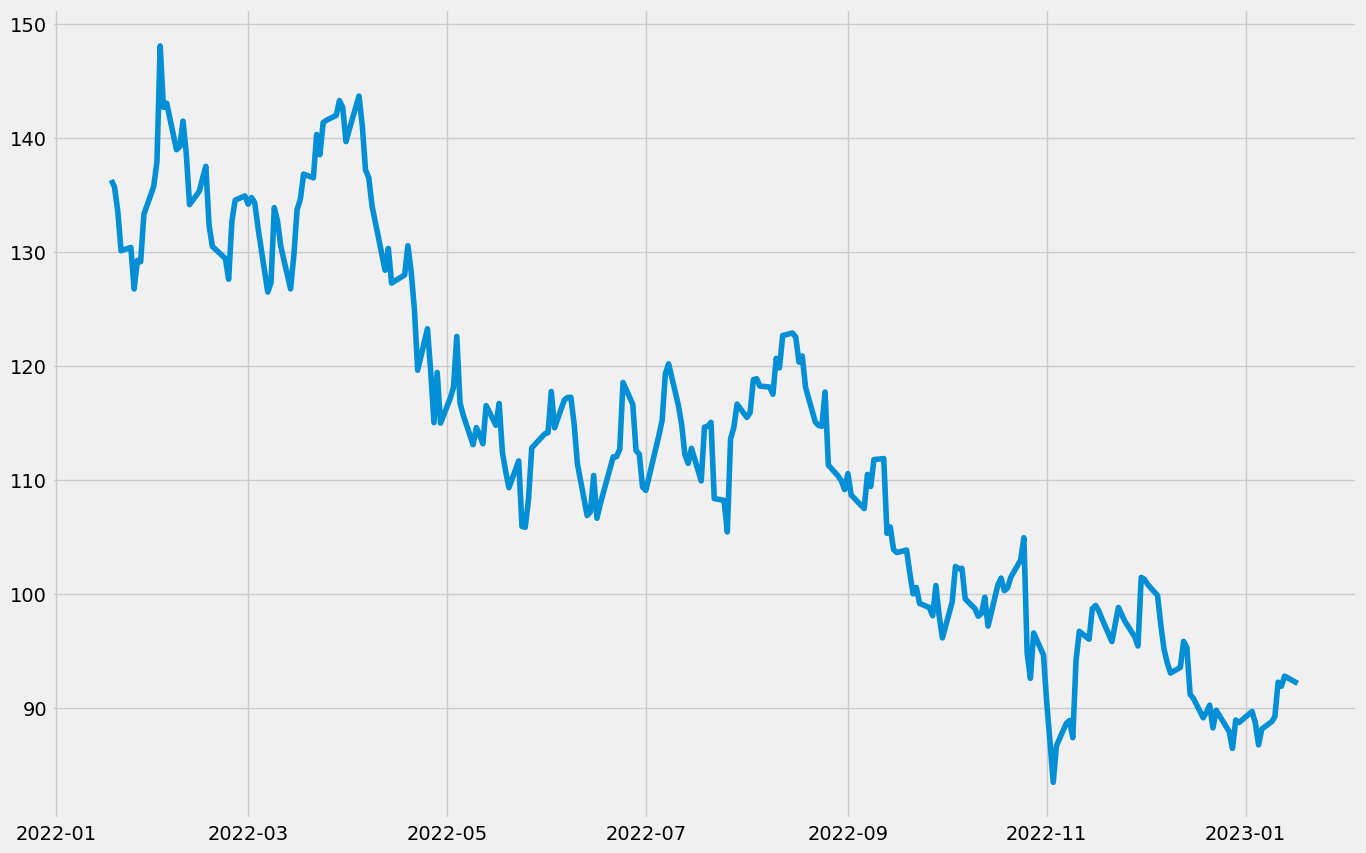

In [11]:
#  visualize the close prices of Google
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

### Using ARIMA for Time Series Forecasting

In [12]:
# To check whether our dataset is stationary or seasonal properly, we can use the seasonal decomposition method that splits 
# the time series data into trend, seasonal, and residuals for a better understanding of the time series data
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data["Close"], model='multiplicative', period = 30)

<Figure size 640x480 with 0 Axes>

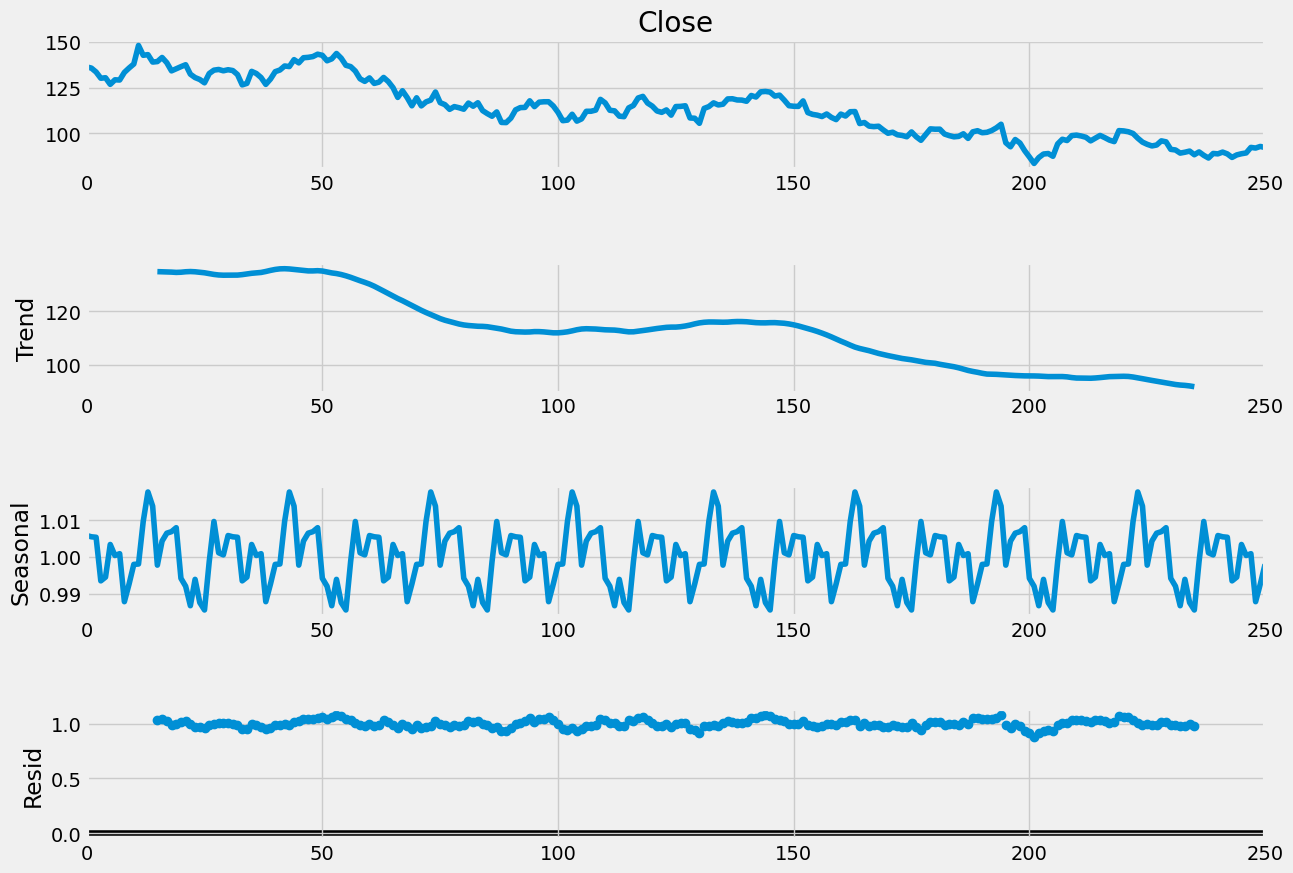

In [13]:
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

### So our data is not stationary it is seasonal

### Need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data.

### Before using the SARIMA model, we will use the ARIMA model. To understand what our output can be.


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

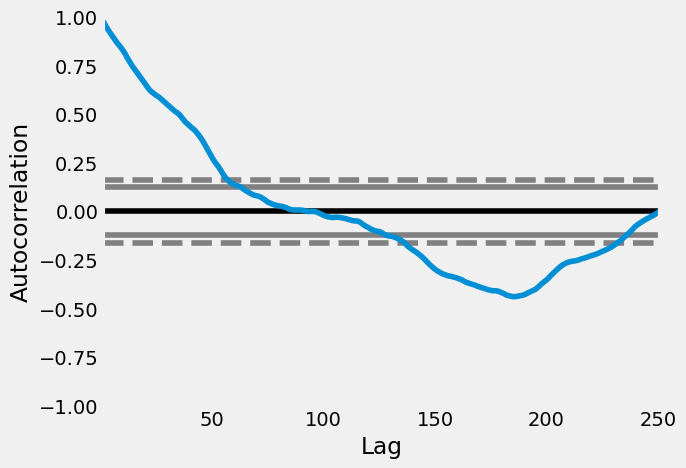

In [14]:
# finding the p value
pd.plotting.autocorrelation_plot(data["Close"])

the curve is moving down after the 5th line of the first boundary p=5

C:\Users\Pratik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


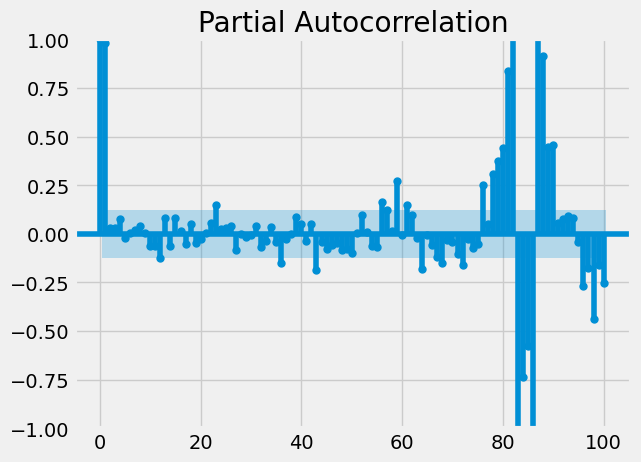

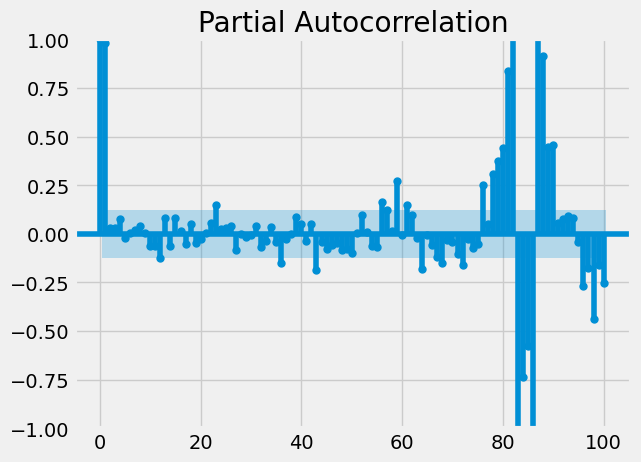

In [15]:
# finding the value of q (moving average)
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data["Close"], lags = 100)

 we can see that only two points are far away from all the points q=2

In [16]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Close'])
print(f'p-value: {adf_test[1]}')

p-value: 0.5640237597018979


In [17]:
p, d, q = 5, 1, 5

import statsmodels.api as sm
model_a = sm.tsa.arima.ARIMA(data["Close"], order=(p,d,q))  
fitted = model_a.fit()  
print(fitted.summary())

C:\Users\Pratik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Pratik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -604.965
Date:                Wed, 18 Jan 2023   AIC                           1231.931
Time:                        18:01:09   BIC                           1270.667
Sample:                             0   HQIC                          1247.521
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0595      2.963      0.020      0.984      -5.748       5.867
ar.L2          0.1291      1.360      0.095      0.924      -2.537       2.795
ar.L3         -0.5455      0.234     -2.330      0.0

C:\Users\Pratik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
predictions_a = fitted.predict()
print(predictions_a)

0        0.000000
1      136.290456
2      135.677651
3      133.630390
4      130.370009
          ...    
246     89.014391
247     89.515312
248     92.226620
249     91.649825
250     92.681589
Name: predicted_mean, Length: 251, dtype: float64


The predicted values are wrong because the data is seasonal. 

In [21]:
# build a SARIMA model
import statsmodels.api as sm
import warnings
model_s=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model_s=model_s.fit()
print(model_s.summary())

C:\Users\Pratik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Pratik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Pratik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Pratik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 5)x(5, 1, 5, 12)   Log Likelihood                -589.833
Date:                            Wed, 18 Jan 2023   AIC                           1221.665
Time:                                    18:05:56   BIC                           1294.583
Sample:                                         0   HQIC                          1251.053
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9398      0.627     -1.498      0.134      -2.169       0.290
ar.L2         -0.2905      0.228   

In [23]:
predictions_s = model_s.predict(len(data), len(data)+10)
print(predictions_s)

251    92.181379
252    91.308013
253    90.616199
254    89.691828
255    90.301060
256    89.925043
257    89.036083
258    88.399922
259    88.462098
260    86.657359
261    86.923231
Name: predicted_mean, dtype: float64


<AxesSubplot:>

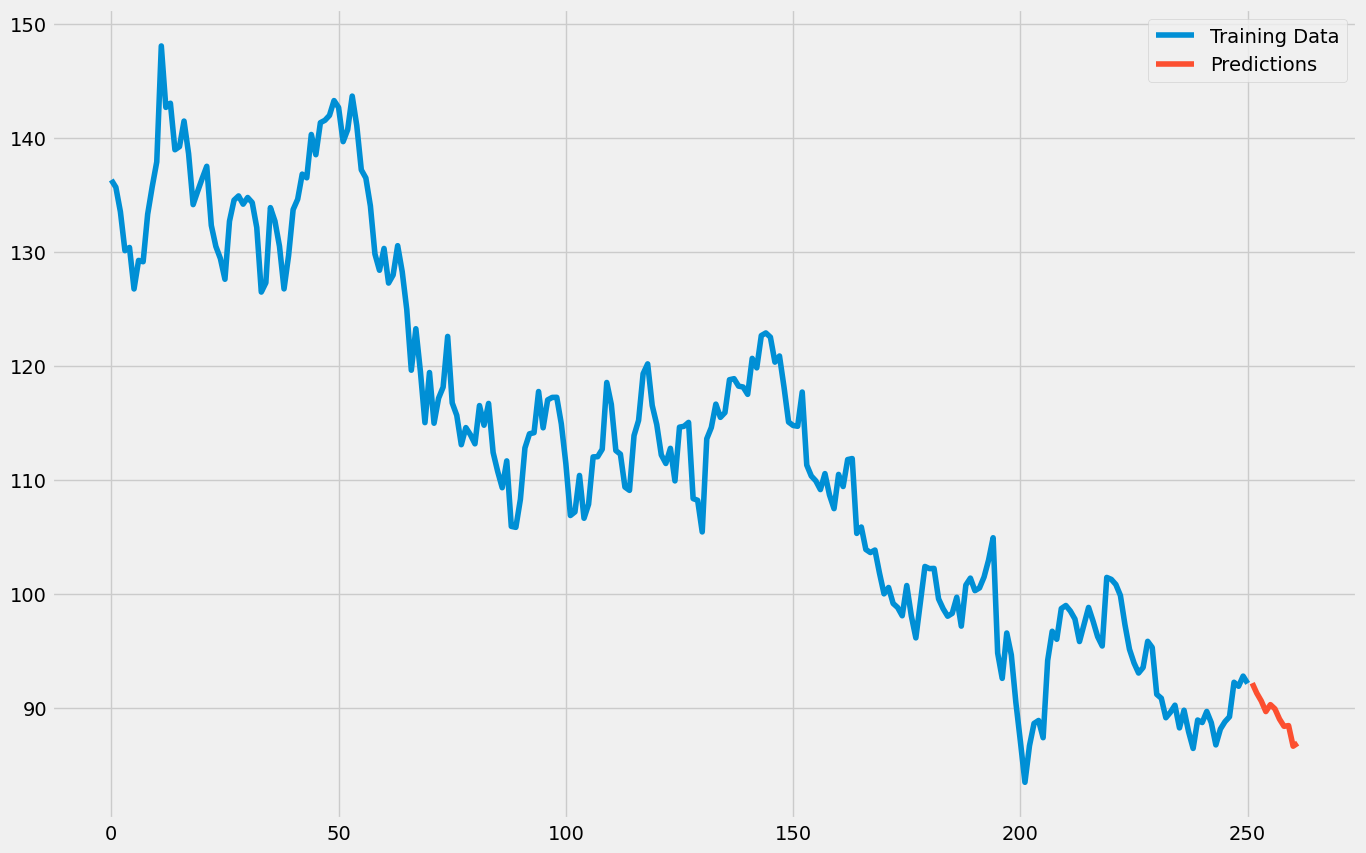

In [24]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions_s.plot(legend=True, label="Predictions")